In [1]:
import sys
sys.path.append('../../../src')
from helpers import *
from scipy.optimize import minimize
%matplotlib notebook

In [2]:
svr = 0.174
D = 0.005
dosage = 1.04e-8 / 0.62

### Numerical solver

In [3]:
def concentration_tree(d, cfrac_c1frac_smfrac_m1frac_e1frac):
    
    """
    d = total protein
    
    Concentrations described by a series of fractions (0-1)
    
    c (cfrac)
        c1 (c1frac)
        c2
    s
        m (smfrac)
            m1 (m1frac)
            m2
        e
            e1 (e1frac)
            e2

    """
    
    cfrac, c1frac, smfrac, m1frac, e1frac = [1 / (1 + np.exp(- i)) for i in cfrac_c1frac_smfrac_m1frac_e1frac]
    c = d * cfrac
    s = d * (1 - cfrac)
    m = s * smfrac * (1 / (svr*D))
    e = s * (1 - smfrac) * (1 / (svr*D))  
    c1 = c * c1frac
    c2 = (c - c1) 
    m1 = m * m1frac
    m2 = (m - m1)
    e1 = e * e1frac
    e2 = (e - e1)
    return c1, c2, m1, m2, e1, e2


def calc_loss(cfrac_c1frac_smfrac_m1frac_e1frac, dosage, wd, wm, we):

    # Concentrations
    c1, c2, m1, m2, e1, e2 = concentration_tree(dosage, cfrac_c1frac_smfrac_m1frac_e1frac)
        
    # Enthalpic terms
    wc1 = 0
    wc2 = wd
    wm1 = wm
    wm2 = 2 * wm + wd
    we1 = we
    we2 = 2 * we + wd

    # Chemical potentials
    muc1 = np.log(c1) - wc1
    muc2 = np.log(c2) - wc2
    mum1 = np.log(m1) - wm1
    mum2 = np.log(m2) - wm2
    mue1 = np.log(e1) - we1
    mue2 = np.log(e2) - we2

    # Loss
    mu_all = np.array([2 * muc1, muc2, 2 * mum1, mum2, 2 * mue1, mue2])
    loss = np.sum((mu_all[:, np.newaxis] - mu_all[np.newaxis, :]) ** 2)
        
    return loss

### Pie charts

In [4]:
def lighten(color, amount=1.8):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

def pie_panel(ax, wd, we, wm, dosage=dosage):
    # Optimise
    x0 = [0, 0, 0, 0, 0]
    res = minimize(calc_loss, x0=x0, args=(dosage, wd, wm, we)).x

    # Get concentrations
    c1, c2, m1, m2, e1, e2 = concentration_tree(dosage, res)
    c_tot = c1 + 1 * c2
    m_tot = (m1 + 1 * m2) * svr*D
    e_tot = (e1 + 1 * e2) * svr*D
    c, m, e = c_tot / dosage, m_tot / dosage, e_tot / dosage
    
    # Figure
    ax.pie([c, e, m], startangle=90, colors=['w', lighten('tab:blue'), 'tab:blue'], wedgeprops={'linewidth': 0.5, 
                                                                                         'edgecolor': 'k'})
    
    ratio = m / e
    ax.text(0.75, -1, f'{ratio:.2f}', fontsize=8)

<IPython.core.display.Javascript object>


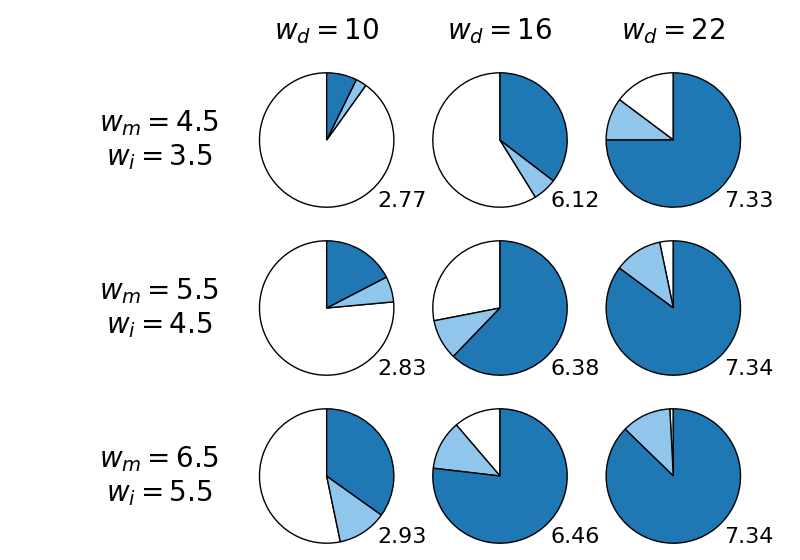

In [5]:
wds = [10, 16, 22]
wms = [4.5, 5.5, 6.5]

fig, ax = plt.subplots(3, 3)
for i, wd in enumerate(wds):
    for j, wm in enumerate(wms):
        pie_panel(ax[j][i], wd, wm-1, wm=wm)

ax[0][0].set_title(r'$w_d = %s$' % wds[0], fontsize=10) 
ax[0][1].set_title(r'$w_d = %s$' % wds[1], fontsize=10) 
ax[0][2].set_title(r'$w_d = %s$' % wds[2], fontsize=10) 
ax[0][0].set_ylabel(r'$w_m = %s$' % wms[0] + '\n' + r'$w_i = %s$' % (wms[0] - 1), 
                    rotation=0, ha='center', va='center', labelpad=30) 
ax[1][0].set_ylabel(r'$w_m = %s$' % wms[1] + '\n' + r'$w_i = %s$' % (wms[1] - 1), 
                    rotation=0, ha='center', va='center', labelpad=30) 
ax[2][0].set_ylabel(r'$w_m = %s$' % wms[2] + '\n' + r'$w_i = %s$' % (wms[2] - 1), 
                    rotation=0, ha='center', va='center', labelpad=30) 

fig.set_size_inches(4, 2.8)
fig.subplots_adjust(wspace=-0.0, hspace=-0.0)
fig.subplots_adjust(left=0.3, right=0.95, top=0.9, bottom=0)
fig.savefig('Figs/pie_eq.png', dpi=600, transparent=True)